# Demonstrate membership inference attacks on means by test statistics

## Tuneable simulation parameters

In [1]:
import numpy as np
from scipy import stats
import math
np.random.seed(123)

## PARAMETERS
n_sims = 10000
n_samples = 10
k_att = 100

## Define utility functions for simulating data and calculating the test statistics

In [2]:
def synthesize(population_prob, n=1):
    """Utility function to simulate sampling from a population.
    Each column is sampled with the coin-flip probability defined in population_prob."""
    x = np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))
    #x[x == 0] = -1  # Sometimes it is convenient in ML to recode as {-1,1}
    return x


## TEST STATISTICS
def test_homer(alice, sample_mean, population_mean):
    """Calculates the Homer test statistic"""
    test_statistic = 1 # fix this
    return test_statistic


def test_dwork(alice, sample_mean, population_mean):
    """Calculates the Dwork et al. test statistic using the population means
    Let `population_mean=referent` if using only a single individual from the population as a referent.
    """
    # We constructed this in class:
    test_statistic = 1 # fix this
    return test_statistic


def h0_distribution(fun, population_prob, population_mean, dist_sims=1000, alpha=0.05):
    """Simulates the sampling distribution under H_0 hypothesis"""
    # An h_0 distribution and critical value generator
    hold = []

    for i in range(dist_sims):
        sample_mean = synthesize(population_prob, n=n_samples).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
        # referent = synthesize(population_prob)[0]

        hold.append(fun(null_alice, sample_mean, population_mean))

    null_dist_vals = np.sort(hold)[::-1]
    return {
        "nulldist": null_dist_vals,
        "critical_val": null_dist_vals[round(alpha * dist_sims)] # We constructed this in class
    }

## Simple graph function for showing the distribution, partitioned by critical value

In [3]:
import matplotlib.pyplot as plt


def show_distribution(x, critical_value, title):
    """Visualize the distribution with a density plot"""

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
    kernel = stats.gaussian_kde(x)
    support = np.linspace(min(x) - kernel.factor, max(x) + kernel.factor, num=500)
    densities = kernel(support)

    flag = support < critical_value
    max_density = max(densities)

    plt.fill_between(support[flag], densities[flag], color='#005aef80')
    plt.fill_between(support[~flag], densities[~flag], color='#ef5c0080')
    plt.axvline(x=critical_value)
    plt.text(x=critical_value, y=0.8*max_density, s=" IN", horizontalalignment='left')
    plt.text(x=critical_value, y=0.8*max_density, s="OUT ", horizontalalignment='right')
    plt.text(x=critical_value, y=0.7*max_density, s=f' {(x > critical_value).mean():.2}', horizontalalignment='left')
    plt.title(title)
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()

## Simulate and graph the H_0 distribution

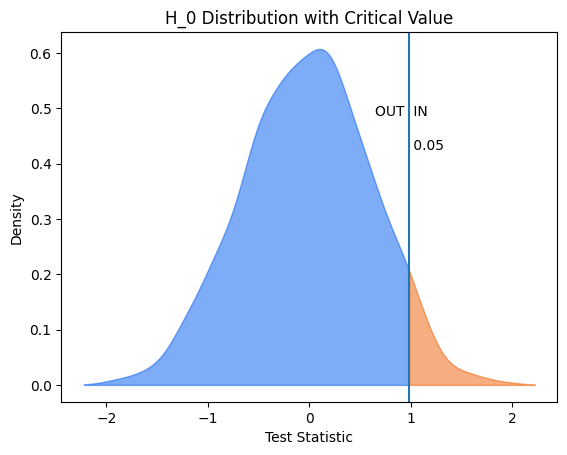

In [4]:
# Generate underlying population attributes
population_prob = np.random.uniform(size=k_att)
population_mean = population_prob
# population_mean = 2*population_prob - 1.  # If we are recoding to {-1,1} in next function

# Find the null distribution
output = h0_distribution(test_dwork, population_prob, population_mean)
testdist = output["nulldist"]
criticalValue = output["critical_val"]
show_distribution(testdist, criticalValue, title="H_0 Distribution with Critical Value")
plt.show()

## Here is our core simulation.  We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

In [5]:
## SIMULATE

# of length n_sims, with 4 values in each
history = np.zeros(shape=(n_sims, 4))

alpha = 0.01
# Find null distributions
h0Dist_Homer = h0_distribution(test_homer, population_prob, population_mean, alpha=alpha)
h0Dist_Dwork = h0_distribution(test_dwork, population_prob, population_mean, alpha=alpha)

for i in range(n_sims):
    # Simulate data
    sample = synthesize(population_prob, n=n_samples)
    sample_mean = sample.mean(axis=0)
    alice = sample[0]
    h0_alice = synthesize(population_prob, n=1)[0]
    # referent = synthesize(population_prob, n=1)[0]

    # Store simulated values
    history[i, :] = [
        # homer statistics
        test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean),
        test_homer(alice=h0_alice, sample_mean=sample_mean, population_mean=population_mean),

        # dwork statistics
        test_dwork(alice=alice, sample_mean=sample_mean, population_mean=population_mean),
        test_dwork(alice=h0_alice, sample_mean=sample_mean, population_mean=population_mean)
    ]

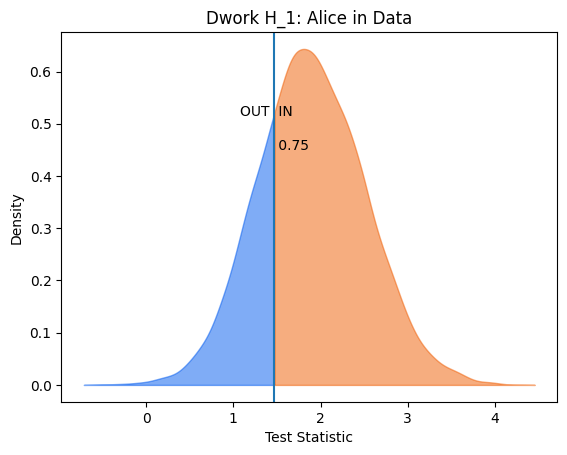

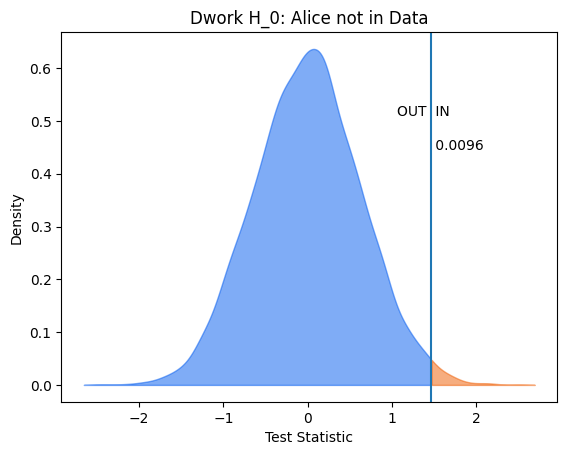

In [6]:
show_distribution(history[:, 2], critical_value=h0Dist_Dwork["critical_val"], title="Dwork H_1: Alice in Data")
show_distribution(history[:, 3], critical_value=h0Dist_Dwork["critical_val"], title="Dwork H_0: Alice not in Data")


## We can expand this simulation by iterating across the number of features available

In [13]:
## SIMULATE WITH VARYING NUMBER OF FEATURES

# of length n_sims, with 4 values in each

log_seq = np.linspace(start=math.log10(5), stop=math.log10(500), num=15)
k_seq = (10**log_seq).astype(int)
print(k_seq)

all_history = np.zeros(shape=(len(k_seq), 3))

alpha = 0.01


for j, k_att in enumerate(k_seq):
    print(f"{j+1} of {len(k_seq)}: {k_att}")

    pop_prob = np.random.uniform(size=k_att)
    pop_mean = pop_prob
    #pop_mean = 2 * pop_prob - 1.  # If we are recoding to {-1,1} in next function

    # Find h_0 distributions
    #h0Dist_Homer = h0_distribution(test_homer, pop_prob, pop_mean, alpha=alpha)
    h0Dist_Dwork = h0_distribution(test_dwork, pop_prob, pop_mean, alpha=alpha)

    #critical_value_Homer = h0Dist_Homer["critical_val"]
    critical_value_Dwork = h0Dist_Dwork["critical_val"]

    temp_history = np.zeros(shape=(n_sims, 2))

    for i in range(n_sims):
        # Simulate data
        h1_dist = synthesize(population_prob=pop_prob, n=n_samples)
        h1_sample_mean = h1_dist.mean(axis=0)
        alice = h1_dist[0]
        h0_dist = synthesize(population_prob=pop_prob, n=n_samples)
        h0_sample_mean = h0_dist.mean(axis=0)

        #referent = synthesize(population_prob=pop_prob, n=1)[0]

        # Store simulated values
        temp_history[i, :] = [
            # dwork statistics
            test_dwork(alice=alice, sample_mean=h1_sample_mean, population_mean=pop_mean),
            test_dwork(alice=alice, sample_mean=h0_sample_mean, population_mean=pop_mean)
            ]

    dwork_membership_FPR = 1 # fix this
    dwork_membership_TPR = 1 # fix this

    all_history[j, :] = [
        k_att,
        dwork_membership_FPR,
        dwork_membership_TPR
    ]


[  5   6   9  13  18  25  35  49  69  96 134 186 258 359 499]
1 of 15: 5
2 of 15: 6
3 of 15: 9
4 of 15: 13
5 of 15: 18
6 of 15: 25
7 of 15: 35
8 of 15: 49
9 of 15: 69
10 of 15: 96
11 of 15: 134
12 of 15: 186
13 of 15: 258
14 of 15: 359
15 of 15: 499


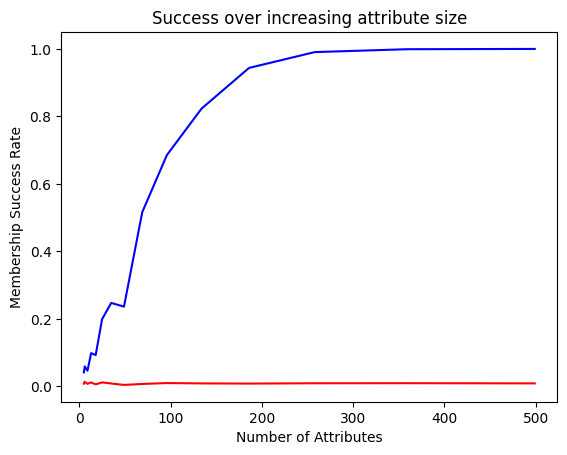

In [14]:
plt.plot(all_history[0:len(k_seq),0], all_history[0:len(k_seq),1], color="red")
plt.plot(all_history[0:len(k_seq),0], all_history[0:len(k_seq),2], color="blue")
plt.xlabel("Number of Attributes")
plt.ylabel("Membership Success Rate")
plt.title("Success over increasing attribute size")
plt.show()